# State Farm Distracted Driver Training Notebook

In [1]:
from fastai.vision.all import *

seed = 42
set_seed(seed, reproducible=True)

%config Completer.use_jedi = False
%matplotlib inline

# matplotlib.pyplot.style.use('dracula')

Set hyperparameters for the notebook here:

In [2]:
# Hyperparameters
valid_pct = 0.2
presize_cpu = 480   # Resized size before batch augmentation on gpu
presize_gpu = 224   # Batch augmentation size on gpu.

In [3]:
path = Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/')
path.ls()

(#4) [Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/driver_imgs_list.csv'),Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/sample_submission.csv'),Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/state-farm-distracted-driver-detection.zip'),Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/imgs')]

In [4]:
Path.BASE_PATH = path

In [5]:
(path/'imgs'/'train').ls()

(#10) [Path('imgs/train/c6'),Path('imgs/train/c7'),Path('imgs/train/c1'),Path('imgs/train/c4'),Path('imgs/train/c5'),Path('imgs/train/c0'),Path('imgs/train/c9'),Path('imgs/train/c3'),Path('imgs/train/c2'),Path('imgs/train/c8')]

In [6]:
(path/'imgs'/'test').ls()

(#79726) [Path('imgs/test/img_57185.jpg'),Path('imgs/test/img_71109.jpg'),Path('imgs/test/img_81875.jpg'),Path('imgs/test/img_101255.jpg'),Path('imgs/test/img_54069.jpg'),Path('imgs/test/img_43476.jpg'),Path('imgs/test/img_49549.jpg'),Path('imgs/test/img_60406.jpg'),Path('imgs/test/img_91426.jpg'),Path('imgs/test/img_4920.jpg')...]

The labels of the training images are in `imgs/driver_imgs_list.csv` which is a comma-delimited list for each image denoting: driver, class name, and image name.

In [7]:
df = pd.read_csv(path/'driver_imgs_list.csv')
df

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [8]:
df['classname'].unique()

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype=object)

**Classes:**

`c0`: normal driving

`c1`: texting right hand

`c2`: phone call right hand

`c3`: texting left hand

`c4`: phone call left hand

`c5`: radio

`c6`: drinking

`c7`: grabbing something from back seat

`c8`: hair and makeup

`c9`: looking away talking

height: 480 width: 640


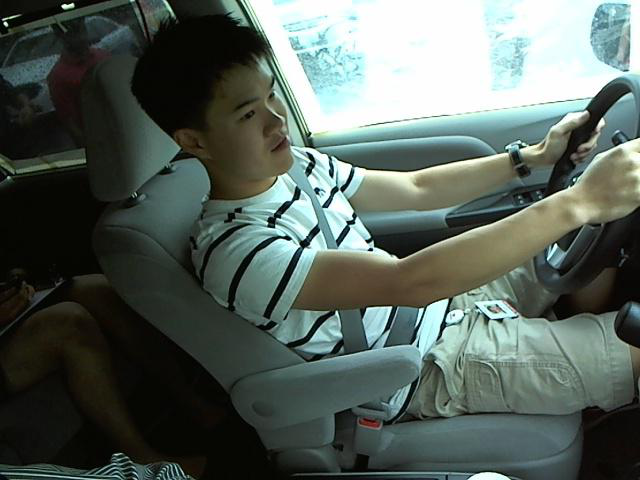

In [9]:
index = 695
im = Image.open(path/'imgs'/'train'/df['classname'][index]/df['img'][index])
print('height:', im.height, 'width:', im.width)
im

In [10]:
def get_x(df): return path/'imgs'/'train'/df['classname']/df['img']
def get_y(df): return df['classname'].split(',')

In [11]:
# dblock = DataBlock(
#     blocks=[ImageBlock, MultiCategoryBlock],
#     get_x=get_x,
#     get_y=get_y,
#     splitter=RandomSplitter(valid_pct=valid_pct),
#     item_tfms=Resize(presize_cpu),
#     batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
# )

# # dsets = dblock.datasets(df)
# # dsets.train[0]
# dls = dblock.dataloaders(df)
# # dls.show_batch(nrows=1, ncols=3)

Check that it's reading the labels correctly,

In [12]:
# dls.vocab, len(dls.vocab)

In [13]:
# learn = cnn_learner(dls, arch=resnet18)
# x,y = to_cpu(dls.train.one_batch())
# activations = learn.model(x)
# print('activations.shape:', activations.shape)

# print('activations:', activations[0])
# loss_func = nn.BCEWithLogitsLoss()
# prtin(loss_func(activations, y))

Create class to setup the model and run it. Save duplicate code.

In [14]:
# test __call__
class test_class():
    def __init__(self, a):
        self.a = a
    def __call__(self):
        print('__call__ activated')
        print('self.a:', self.a)
    def run():
        print('run activated')
        print('self.a:', self.a)

tc = test_class(10)
tc()

__call__ activated
self.a: 10


In [15]:
# learn.lr_find??
Learner.lr_find??

Signature:
Learner.lr_find(
    self: fastai.learner.Learner,
    start_lr=1e-07,
    end_lr=10,
    num_it=100,
    stop_div=True,
    show_plot=True,
    suggest_funcs=<function valley at 0x7f3ef11f5b80>,
)
Source:   
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggest_funcs=(SuggestionMethod.Valley)):
    "Launch a mock training to find a good learning rate and return suggestions based on `suggest_funcs` as a named tuple"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if suggest_funcs is not None:
        lrs, losses = tensor(self.recorder.lrs[num_it//10:-5]), tensor(self.recorder.losses[num_it//10:-5])
        nan_idxs = torch.nonzero(torch.isnan(losses.view(-1)))
        if len(nan_idxs) > 0:
            drop_idx = min(nan_idxs)
            lrs = lrs[:drop_idx]
            losses = los

In [16]:
class CNN_Presized():
    def __init__(self, df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size, arch, weight_decay, monitor='valid_loss'):
        self.df             = df
        self.get_x          = get_x
        self.get_y          = get_y
        self.valid_pct      = valid_pct
        self.presize_cpu    = presize_cpu
        self.presize_gpu    = presize_gpu
        self.batch_size     = batch_size
        self.arch           = arch
        self.weight_decay   = weight_decay
        self.monitor        = monitor
    # def __call__(self):
        dblock = DataBlock(
            blocks=[ImageBlock, MultiCategoryBlock],
            get_x=self.get_x,
            get_y=self.get_y,
            splitter=RandomSplitter(valid_pct=self.valid_pct),
            item_tfms=Resize(self.presize_cpu),
            batch_tfms=aug_transforms(size=self.presize_gpu, min_scale=0.75)
        )
        dls = dblock.dataloaders(self.df, bs=self.batch_size)
        loss_func = nn.BCEWithLogitsLoss()
        self.learn = cnn_learner(
            dls,
            arch=self.arch,
            loss_func=loss_func,
            metrics=F1ScoreMulti(thresh=0.5),
            cbs=[
                # ShowGraphCallback(),
                SaveModelCallback(
                    monitor=self.monitor,
                    # fname=str(self.arch+'_'+self.monitor+'_'+self.presize_gpu+'px'+'_'+'wd'+self.weight_decay)
                    fname=str(self.arch).split()[1]+'_'+self.monitor+'_'+str(self.presize_cpu)+'cpx'+'_'+str(self.presize_gpu)+'gpx'+'_'+str(self.weight_decay)+'wd'
                ),
                EarlyStoppingCallback(
                    monitor=self.monitor,
                    patience=3
                )
            ]
        )
        # self.learn = learn
        # return learn
    def lrs(self):
        self.learning_rates = self.learn.lr_find(suggest_funcs=(SuggestionMethod.Valley,SuggestionMethod.Minimum,SuggestionMethod.Slide))
        print(self.learning_rates)
    def run(self, n_epochs, base_lr='valley'):
        self.n_epochs = n_epochs
        if base_lr=='valley': base_lr = self.learning_rates.valley
        if base_lr=='minimum': base_lr = self.learning_rates.minimum
        if base_lr=='slide': base_lr = self.learning_rates.slide
        self.learn.fine_tune(self.n_epochs, base_lr=base_lr, wd=self.weight_decay)
    def export(self, pkl_name): self.learn.export(str(self.pkl_name) + '.pkl')
    def load(self, pkl_name): self.learn.load_learner(str(self.pkl_name) + '.pkl', cpu=False)

# Resnet18 Presize

## Presize 480/224

In [ ]:
presize_cpu = 480
presize_gpu = 224

### wd = 0.1

In [17]:
res18_01 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet18, weight_decay=0.1)

SuggestedLRs(valley=0.002511886414140463, minimum=0.03630780577659607, slide=0.02290867641568184)
valley: 0.002511886414140463
minimum: 0.03630780577659607
slide: 0.02290867641568184


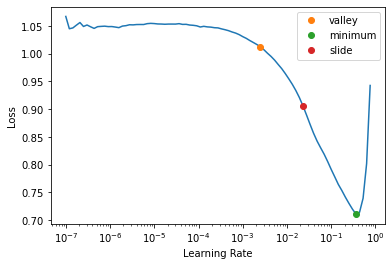

In [18]:
res18_01.lrs()

In [19]:
# testing
res18_01.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.711392,0.287041,0.698483,01:04


Better model found at epoch 0 with valid_loss value: 0.28704050183296204.


epoch,train_loss,valid_loss,f1_score,time
0,0.265036,0.106712,0.878248,00:58
1,0.121458,0.027148,0.961193,01:00
2,0.053176,0.012905,0.981741,01:01
3,0.026865,0.007852,0.989088,01:00
4,0.016115,0.006254,0.991701,01:01
5,0.012503,0.006106,0.991719,01:00


Better model found at epoch 0 with valid_loss value: 0.10671225190162659.
Better model found at epoch 1 with valid_loss value: 0.027147715911269188.
Better model found at epoch 2 with valid_loss value: 0.012905114330351353.
Better model found at epoch 3 with valid_loss value: 0.007852411828935146.
Better model found at epoch 4 with valid_loss value: 0.006254047155380249.
Better model found at epoch 5 with valid_loss value: 0.0061057074926793575.


SuggestedLRs(valley=0.00010964782268274575, minimum=1.318256749982538e-07, slide=0.0002290867705596611)
valley: 0.00010964782268274575
minimum: 1.318256749982538e-07
slide: 0.0002290867705596611


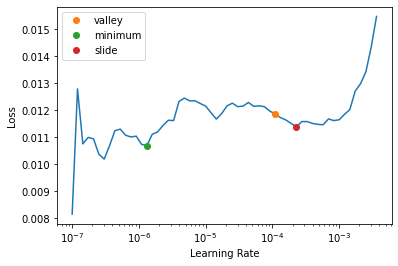

In [20]:
res18_01.lrs()

In [21]:
res18_01.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.011190,0.005841,0.991742,00:55


Better model found at epoch 0 with valid_loss value: 0.00584137300029397.


epoch,train_loss,valid_loss,f1_score,time
0,0.010096,0.005674,0.992216,00:58
1,0.010044,0.005499,0.992517,01:00


Better model found at epoch 0 with valid_loss value: 0.0056744348257780075.
Better model found at epoch 1 with valid_loss value: 0.005498741753399372.


SuggestedLRs(valley=1.737800812406931e-05, minimum=5.248074739938602e-06, slide=0.0002754228771664202)
valley: 1.737800812406931e-05
minimum: 5.248074739938602e-06
slide: 0.0002754228771664202


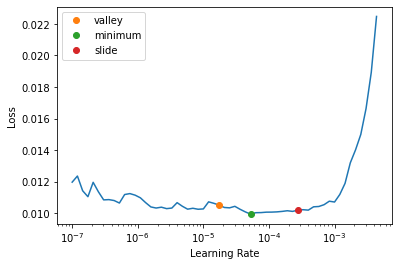

In [22]:
res18_01.lrs()

In [23]:
res18_01.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.009618,0.005490,0.992430,00:54


Better model found at epoch 0 with valid_loss value: 0.005490328185260296.


epoch,train_loss,valid_loss,f1_score,time
0,0.010044,0.005480,0.992354,00:57
1,0.010305,0.005407,0.992331,00:59


Better model found at epoch 0 with valid_loss value: 0.005479692947119474.
Better model found at epoch 1 with valid_loss value: 0.005407053045928478.


SuggestedLRs(valley=9.120108734350652e-05, minimum=2.7542287716642023e-05, slide=0.0002754228771664202)
valley: 9.120108734350652e-05
minimum: 2.7542287716642023e-05
slide: 0.0002754228771664202


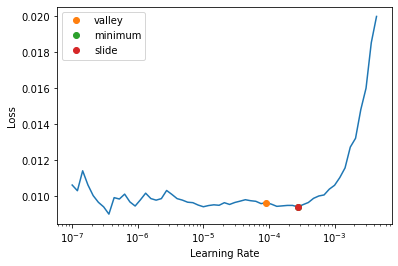

In [24]:
res18_01.lrs()

## wd = 0.2

In [17]:
res18_02 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet18, weight_decay=0.2)

SuggestedLRs(valley=0.002511886414140463, minimum=0.03630780577659607, slide=0.02290867641568184)


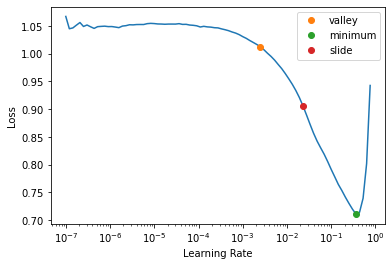

In [18]:
res18_02.lrs()

In [19]:
res18_02.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.710903,0.288017,0.698444,01:03


Better model found at epoch 0 with valid_loss value: 0.28801706433296204.


epoch,train_loss,valid_loss,f1_score,time
0,0.265113,0.107524,0.880252,00:58
1,0.121464,0.027856,0.960200,01:00
2,0.053207,0.012792,0.982806,00:59
3,0.026924,0.008008,0.988629,01:00
4,0.016133,0.006320,0.991605,01:00
5,0.012489,0.006152,0.992134,01:00


Better model found at epoch 0 with valid_loss value: 0.10752366483211517.
Better model found at epoch 1 with valid_loss value: 0.02785569243133068.
Better model found at epoch 2 with valid_loss value: 0.012791642919182777.
Better model found at epoch 3 with valid_loss value: 0.008008487522602081.
Better model found at epoch 4 with valid_loss value: 0.006320093758404255.
Better model found at epoch 5 with valid_loss value: 0.0061519090086221695.


SuggestedLRs(valley=0.00015848931798245758, minimum=1.318256749982538e-07, slide=0.0002290867705596611)


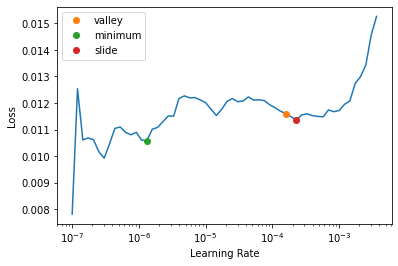

In [20]:
res18_02.lrs()

In [21]:
res18_02.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.011136,0.005823,0.992159,00:57


Better model found at epoch 0 with valid_loss value: 0.005822929088026285.


epoch,train_loss,valid_loss,f1_score,time
0,0.009923,0.005587,0.992053,00:58
1,0.009692,0.005152,0.992964,01:00
2,0.009239,0.005149,0.992988,00:58


Better model found at epoch 0 with valid_loss value: 0.005586607381701469.
Better model found at epoch 1 with valid_loss value: 0.005151967518031597.
Better model found at epoch 2 with valid_loss value: 0.005148968193680048.


SuggestedLRs(valley=5.248074739938602e-05, minimum=2.7542287716642023e-05, slide=0.0002290867705596611)


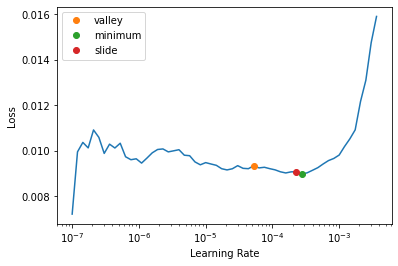

In [22]:
res18_02.lrs()

In [23]:
res18_02.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.009035,0.005092,0.992861,00:57


Better model found at epoch 0 with valid_loss value: 0.005091947037726641.


epoch,train_loss,valid_loss,f1_score,time
0,0.009357,0.004966,0.993101,01:01
1,0.009043,0.004895,0.993439,01:02
2,0.008660,0.004813,0.993218,01:03


Better model found at epoch 0 with valid_loss value: 0.00496626878157258.
Better model found at epoch 1 with valid_loss value: 0.004894875921308994.
Better model found at epoch 2 with valid_loss value: 0.00481298565864563.


SuggestedLRs(valley=2.0892961401841603e-05, minimum=1.9054606673307718e-05, slide=0.0002290867705596611)


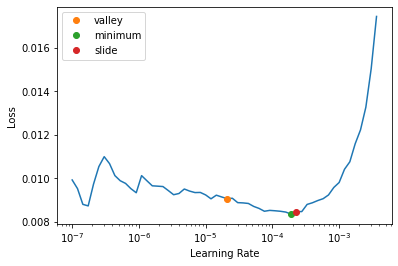

In [24]:
res18_02.lrs()

In [26]:
res18_02.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.008350,0.004875,0.993342,01:00


Better model found at epoch 0 with valid_loss value: 0.004874630831182003.


epoch,train_loss,valid_loss,f1_score,time
0,0.008351,0.004783,0.993445,00:59
1,0.008025,0.004750,0.993329,00:59
2,0.008102,0.004763,0.993331,00:59


Better model found at epoch 0 with valid_loss value: 0.004782885778695345.
Better model found at epoch 1 with valid_loss value: 0.004750004969537258.


SuggestedLRs(valley=1.0964781722577754e-06, minimum=9.12010818865383e-08, slide=0.00015848931798245758)


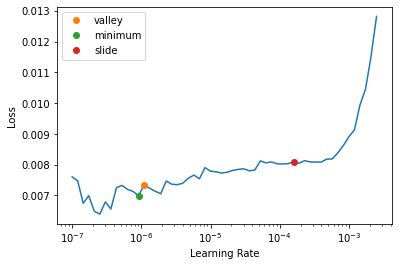

In [27]:
res18_02.lrs()

## wd = 0.3

In [28]:
res18_03 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet18, weight_decay=0.3)

SuggestedLRs(valley=0.001737800776027143, minimum=0.03630780577659607, slide=0.019054606556892395)


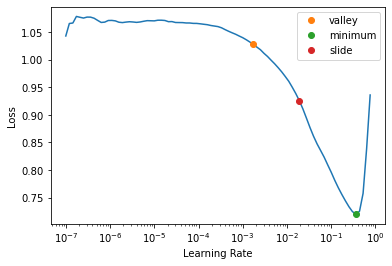

In [29]:
res18_03.lrs()

In [30]:
res18_03.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.779710,0.419797,0.543095,00:57


Better model found at epoch 0 with valid_loss value: 0.419796884059906.


epoch,train_loss,valid_loss,f1_score,time
0,0.437054,0.246336,0.774844,00:59
1,0.235174,0.065472,0.934618,00:59
2,0.107780,0.026356,0.970918,00:59
3,0.055687,0.016266,0.980223,00:58
4,0.035197,0.013325,0.982831,00:59
5,0.028171,0.012981,0.982739,01:00


Better model found at epoch 0 with valid_loss value: 0.24633634090423584.
Better model found at epoch 1 with valid_loss value: 0.06547226756811142.
Better model found at epoch 2 with valid_loss value: 0.026356304064393044.
Better model found at epoch 3 with valid_loss value: 0.016265878453850746.
Better model found at epoch 4 with valid_loss value: 0.01332542672753334.
Better model found at epoch 5 with valid_loss value: 0.012980800122022629.


SuggestedLRs(valley=0.00019054606673307717, minimum=6.309573450380412e-08, slide=0.0008317637839354575)


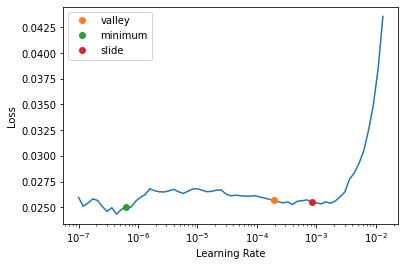

In [31]:
res18_03.lrs()

In [32]:
res18_03.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.024790,0.011681,0.983745,01:00


Better model found at epoch 0 with valid_loss value: 0.011680667288601398.


epoch,train_loss,valid_loss,f1_score,time
0,0.022760,0.010569,0.985267,01:02
1,0.020604,0.009657,0.986630,01:02
2,0.019210,0.009362,0.986586,01:03


Better model found at epoch 0 with valid_loss value: 0.01056933868676424.
Better model found at epoch 1 with valid_loss value: 0.00965678971260786.
Better model found at epoch 2 with valid_loss value: 0.009362262673676014.


SuggestedLRs(valley=1.737800812406931e-05, minimum=9.120108734350651e-06, slide=0.0004786300996784121)


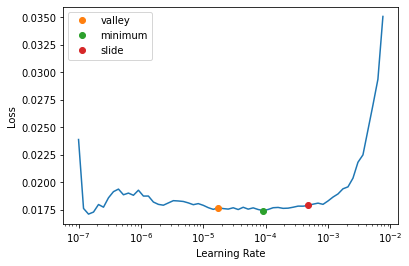

In [33]:
res18_03.lrs()

In [34]:
res18_03.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.018557,0.009351,0.986886,00:55


Better model found at epoch 0 with valid_loss value: 0.009351302869617939.


epoch,train_loss,valid_loss,f1_score,time
0,0.018408,0.009228,0.986854,00:58
1,0.018192,0.009066,0.987066,00:59
2,0.018199,0.009051,0.987130,00:58


Better model found at epoch 0 with valid_loss value: 0.009228193201124668.
Better model found at epoch 1 with valid_loss value: 0.009066328406333923.
Better model found at epoch 2 with valid_loss value: 0.009050928987562656.


SuggestedLRs(valley=7.585775892948732e-05, minimum=6.30957365501672e-06, slide=0.0003311311302240938)


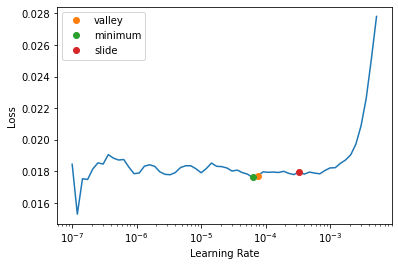

In [35]:
res18_03.lrs()

## Presize 480/480

In [17]:
presize_cpu = 480
presize_gpu = 480

In [18]:
res18_11 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=64, arch=resnet18, weight_decay=0.1)

SuggestedLRs(valley=0.00363078061491251, minimum=0.025118863582611083, slide=0.015848932787775993)


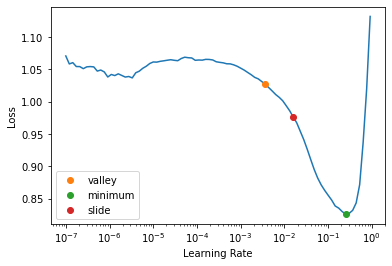

In [19]:
res18_11.lrs()

In [20]:
res18_11.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.215737,0.115425,0.771085,01:46


Better model found at epoch 0 with valid_loss value: 0.11542507261037827.


epoch,train_loss,valid_loss,f1_score,time
0,0.035378,0.015688,0.974860,02:06
1,0.015946,0.009112,0.985106,02:07
2,0.009538,0.004731,0.991693,02:07
3,0.004248,0.002491,0.996326,02:07
4,0.002144,0.001223,0.998647,02:08
5,0.001477,0.001145,0.998518,02:07


Better model found at epoch 0 with valid_loss value: 0.01568784937262535.
Better model found at epoch 1 with valid_loss value: 0.00911172665655613.
Better model found at epoch 2 with valid_loss value: 0.004731259308755398.
Better model found at epoch 3 with valid_loss value: 0.002490666462108493.
Better model found at epoch 4 with valid_loss value: 0.00122318253852427.
Better model found at epoch 5 with valid_loss value: 0.0011449394514784217.


SuggestedLRs(valley=0.00015848931798245758, minimum=1.2022644114040304e-06, slide=3.630780702224001e-05)


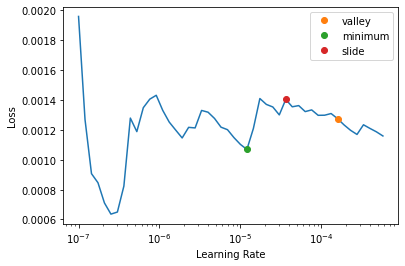

In [21]:
res18_11.lrs()

In [22]:
res18_11.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.001115,0.001136,0.998626,01:48


Better model found at epoch 0 with valid_loss value: 0.001135614118538797.


epoch,train_loss,valid_loss,f1_score,time
0,0.000929,0.001104,0.998607,02:07
1,0.001036,0.001167,0.998478,02:07
2,0.000687,0.001085,0.998709,02:07


Better model found at epoch 0 with valid_loss value: 0.00110414728987962.
Better model found at epoch 2 with valid_loss value: 0.0010853507556021214.


SuggestedLRs(valley=1.4454397387453355e-05, minimum=6.30957365501672e-06, slide=3.0199516913853586e-05)


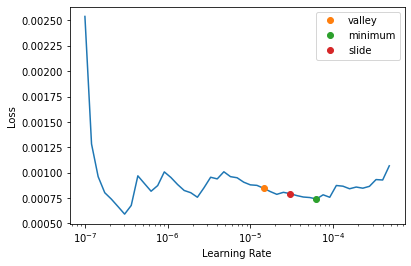

In [24]:
res18_11.lrs()

In [25]:
res18_11.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.000712,0.001089,0.998709,01:47


Better model found at epoch 0 with valid_loss value: 0.0010888611432164907.


epoch,train_loss,valid_loss,f1_score,time
0,0.000837,0.001113,0.998607,02:07
1,0.001066,0.001141,0.998375,02:08
2,0.000744,0.001069,0.998709,02:07


Better model found at epoch 0 with valid_loss value: 0.001113122678361833.
Better model found at epoch 2 with valid_loss value: 0.001069122925400734.


SuggestedLRs(valley=7.585775892948732e-05, minimum=1.58489319801447e-07, slide=3.0199516913853586e-05)


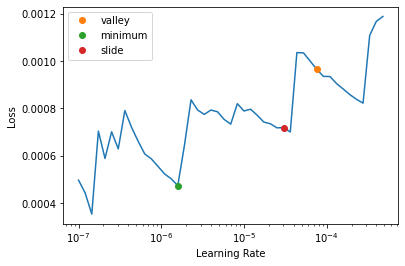

In [26]:
res18_11.lrs()

In [27]:
res18_11.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.000805,0.001139,0.998478,01:47


Better model found at epoch 0 with valid_loss value: 0.001138719148002565.


epoch,train_loss,valid_loss,f1_score,time
0,0.000507,0.001125,0.998607,02:07
1,0.000827,0.001117,0.998478,02:08
2,0.001015,0.001076,0.998709,02:08


Better model found at epoch 0 with valid_loss value: 0.001125027542002499.
Better model found at epoch 1 with valid_loss value: 0.0011173603124916553.
Better model found at epoch 2 with valid_loss value: 0.0010760667501017451.


SuggestedLRs(valley=1.0964781722577754e-06, minimum=3.311311274956097e-07, slide=1.737800812406931e-05)


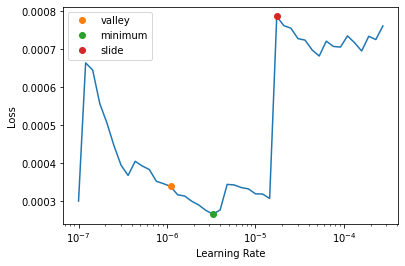

In [28]:
res18_11.lrs()

In [29]:
res18_11.run(4, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.000606,0.001159,0.998478,01:47


Better model found at epoch 0 with valid_loss value: 0.0011590090580284595.


epoch,train_loss,valid_loss,f1_score,time
0,0.000616,0.001093,0.998478,02:08
1,0.000675,0.001085,0.998709,02:08
2,0.000796,0.001170,0.998375,02:08
3,0.000633,0.001130,0.998626,02:08


Better model found at epoch 0 with valid_loss value: 0.001092635910026729.
Better model found at epoch 1 with valid_loss value: 0.001085351686924696.


SuggestedLRs(valley=6.918309736647643e-06, minimum=6.309573450380412e-08, slide=2.0892961401841603e-05)


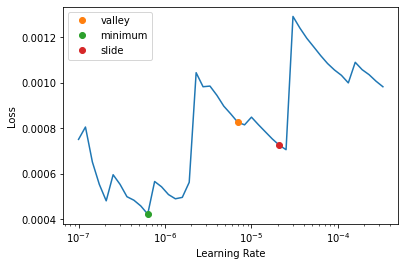

In [32]:
res18_11.lrs()

## resnet18 wd practice 0.1

SuggestedLRs(valley=0.0014454397605732083)

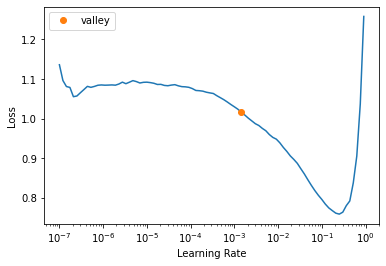

In [16]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=78)

monitor='valid_loss'
wd = 0.1

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_480px_wd0.1'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.646059,0.402735,0.630097,13:19
1,0.271672,0.179902,0.782834,13:11


Better model found at epoch 0 with valid_loss value: 0.402734637260437.


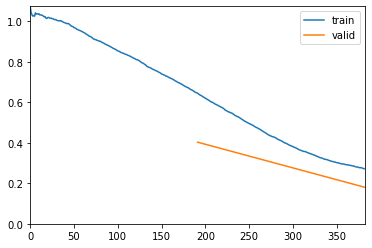

Better model found at epoch 1 with valid_loss value: 0.17990228533744812.


epoch,train_loss,valid_loss,f1_score,time
0,0.181476,0.141005,0.837340,13:23
1,0.150741,0.121096,0.859698,13:18
2,0.131026,0.109973,0.856069,13:03
3,0.114223,0.106285,0.880679,13:05
4,0.101234,0.096163,0.884602,13:12
5,0.092845,0.095545,0.888547,13:07
6,0.087124,0.091731,0.897277,13:05
7,0.079627,0.095665,0.896837,13:12
8,0.070446,0.096952,0.897103,13:07
9,0.066582,0.098668,0.888705,13:16


Better model found at epoch 0 with valid_loss value: 0.14100462198257446.


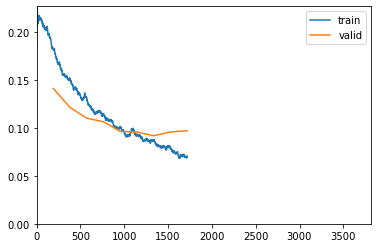

Better model found at epoch 1 with valid_loss value: 0.1210961565375328.
Better model found at epoch 2 with valid_loss value: 0.10997337102890015.
Better model found at epoch 3 with valid_loss value: 0.10628479719161987.
Better model found at epoch 4 with valid_loss value: 0.0961630642414093.
Better model found at epoch 5 with valid_loss value: 0.09554502367973328.
Better model found at epoch 6 with valid_loss value: 0.09173145145177841.
No improvement since epoch 6: early stopping


In [17]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [18]:
learn.export('plant_resnet18_vl_480px_wd0.1.pkl') # save the model

## resnet18 wd practice 0.2

SuggestedLRs(valley=0.001737800776027143)

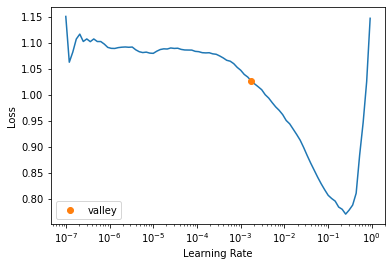

In [19]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=78)

monitor='valid_loss'
wd = 0.2

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_480px_wd0.2'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.623633,0.375557,0.651911,13:14
1,0.255996,0.168388,0.797024,13:05


Better model found at epoch 0 with valid_loss value: 0.3755573332309723.


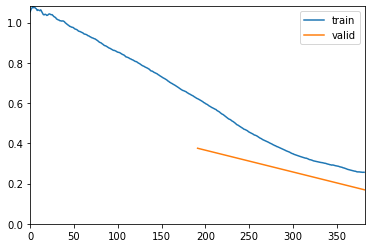

Better model found at epoch 1 with valid_loss value: 0.168387770652771.


epoch,train_loss,valid_loss,f1_score,time
0,0.171310,0.122954,0.851468,13:23
1,0.143523,0.107935,0.860894,13:12
2,0.125214,0.096904,0.872450,13:20
3,0.112001,0.092667,0.886428,13:36
4,0.101885,0.092049,0.883576,13:21
5,0.089050,0.087339,0.892631,13:15
6,0.084737,0.084242,0.893704,13:16
7,0.079142,0.085799,0.891754,13:22
8,0.071387,0.084691,0.898901,13:02
9,0.063966,0.082062,0.900784,13:10


Better model found at epoch 0 with valid_loss value: 0.12295444309711456.


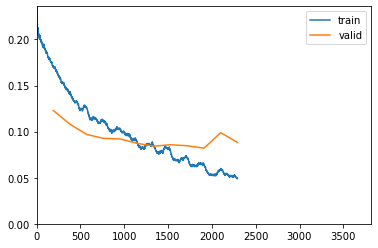

Better model found at epoch 1 with valid_loss value: 0.1079353615641594.
Better model found at epoch 2 with valid_loss value: 0.09690351039171219.
Better model found at epoch 3 with valid_loss value: 0.09266677498817444.
Better model found at epoch 4 with valid_loss value: 0.092048779129982.
Better model found at epoch 5 with valid_loss value: 0.08733892440795898.
Better model found at epoch 6 with valid_loss value: 0.08424210548400879.
Better model found at epoch 9 with valid_loss value: 0.0820620059967041.
No improvement since epoch 9: early stopping


In [20]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [21]:
learn.export('plant_resnet18_vl_480px_wd0.2.pkl') # save the model

## resnet18 wd practice 0.3

SuggestedLRs(valley=0.0014454397605732083)

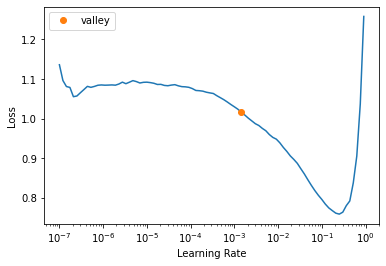

In [16]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=78)

monitor='valid_loss'
wd = 0.3

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_480px_wd0.3'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.644781,0.403347,0.630126,13:09
1,0.270044,0.179962,0.783084,12:53


Better model found at epoch 0 with valid_loss value: 0.4033474922180176.


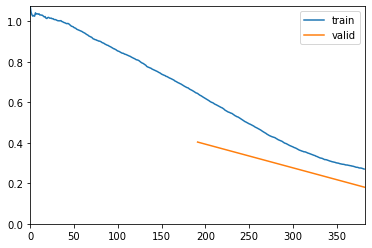

Better model found at epoch 1 with valid_loss value: 0.17996172606945038.


epoch,train_loss,valid_loss,f1_score,time
0,0.179347,0.140080,0.838540,13:11
1,0.148888,0.120743,0.860130,13:04
2,0.129696,0.109954,0.856010,13:09
3,0.112601,0.104790,0.880512,13:13
4,0.100008,0.095923,0.882626,12:55
5,0.092671,0.095630,0.889522,13:01
6,0.087035,0.091252,0.898290,13:00
7,0.080155,0.094147,0.895137,13:06
8,0.070510,0.098384,0.892239,12:57
9,0.065413,0.094900,0.893731,12:55


Better model found at epoch 0 with valid_loss value: 0.14008024334907532.


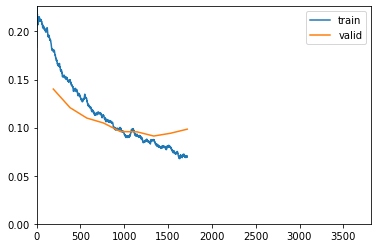

Better model found at epoch 1 with valid_loss value: 0.12074344605207443.
Better model found at epoch 2 with valid_loss value: 0.1099538579583168.
Better model found at epoch 3 with valid_loss value: 0.10478952527046204.
Better model found at epoch 4 with valid_loss value: 0.09592336416244507.
Better model found at epoch 5 with valid_loss value: 0.09562993049621582.
Better model found at epoch 6 with valid_loss value: 0.09125208109617233.
No improvement since epoch 6: early stopping


In [17]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [18]:
learn.export('plant_resnet18_vl_480px_wd0.3.pkl') # save the model

## resnet18 wd practice 0.4

SuggestedLRs(valley=0.001737800776027143)

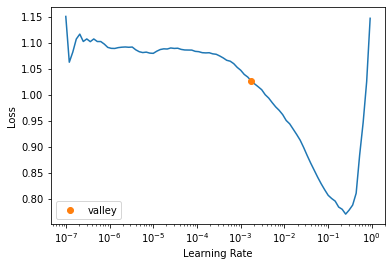

In [19]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=78)

monitor='valid_loss'
wd = 0.4

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_480px_wd0.4'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.622146,0.376308,0.651815,13:00
1,0.254512,0.168937,0.796542,13:00


Better model found at epoch 0 with valid_loss value: 0.376307874917984.


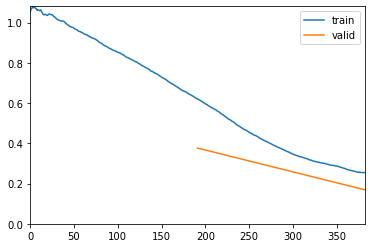

Better model found at epoch 1 with valid_loss value: 0.16893652081489563.


epoch,train_loss,valid_loss,f1_score,time
0,0.169477,0.122717,0.849981,14:22
1,0.141585,0.107568,0.860586,13:41
2,0.123293,0.096606,0.874423,13:13
3,0.111304,0.092976,0.886565,13:06
4,0.100851,0.093485,0.885610,14:04
5,0.088354,0.086772,0.896768,13:14
6,0.084352,0.084293,0.889739,13:12
7,0.078493,0.082865,0.897159,13:09
8,0.070342,0.088877,0.897018,13:06
9,0.063563,0.081109,0.898380,13:17


Better model found at epoch 0 with valid_loss value: 0.12271681427955627.


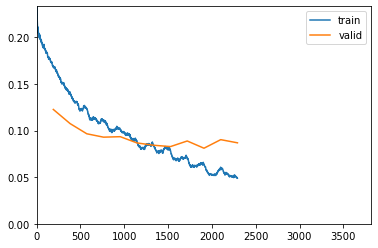

Better model found at epoch 1 with valid_loss value: 0.10756772756576538.
Better model found at epoch 2 with valid_loss value: 0.09660612046718597.
Better model found at epoch 3 with valid_loss value: 0.09297595173120499.
Better model found at epoch 5 with valid_loss value: 0.0867718905210495.
Better model found at epoch 6 with valid_loss value: 0.08429287374019623.
Better model found at epoch 7 with valid_loss value: 0.08286482095718384.
Better model found at epoch 9 with valid_loss value: 0.08110865205526352.
No improvement since epoch 9: early stopping


In [20]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [21]:
learn.export('plant_resnet18_vl_480px_wd0.4.pkl') # save the model

# Resnet34 480 Presize

## resnet34 wd practice 0.1

SuggestedLRs(valley=0.0020892962347716093)

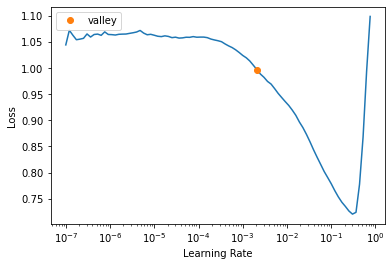

In [16]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=116)

monitor='valid_loss'
wd = 0.1

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet34_vl_480px_wd0.1'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.672161,0.398471,0.630629,13:01
1,0.303429,0.179740,0.787076,12:59


Better model found at epoch 0 with valid_loss value: 0.39847105741500854.


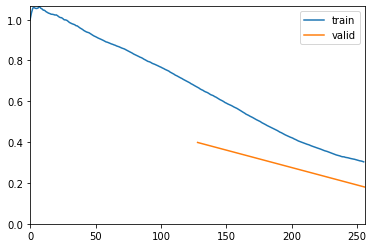

Better model found at epoch 1 with valid_loss value: 0.17973989248275757.


epoch,train_loss,valid_loss,f1_score,time
0,0.164104,0.126811,0.842814,13:08
1,0.134328,0.108845,0.869844,13:06
2,0.113071,0.103615,0.873779,13:11
3,0.099516,0.097647,0.883637,13:07
4,0.093518,0.096737,0.885287,13:06
5,0.083410,0.093586,0.884091,13:07
6,0.074446,0.092970,0.896449,13:11
7,0.070907,0.098327,0.893436,13:11
8,0.060109,0.099097,0.890124,13:05
9,0.054734,0.100413,0.892326,13:07


Better model found at epoch 0 with valid_loss value: 0.12681111693382263.


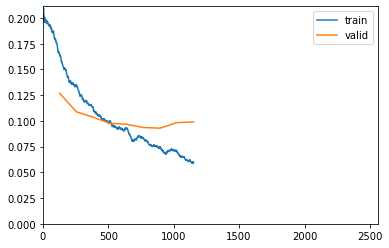

Better model found at epoch 1 with valid_loss value: 0.10884473472833633.
Better model found at epoch 2 with valid_loss value: 0.10361503809690475.
Better model found at epoch 3 with valid_loss value: 0.09764698892831802.
Better model found at epoch 4 with valid_loss value: 0.0967368334531784.
Better model found at epoch 5 with valid_loss value: 0.09358573704957962.
Better model found at epoch 6 with valid_loss value: 0.09297006577253342.
No improvement since epoch 6: early stopping


In [17]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [18]:
learn.export('plant_resnet34_vl_480px_wd0.1.pkl') # save the model

## resnet34 wd practice 0.2

SuggestedLRs(valley=0.001737800776027143)

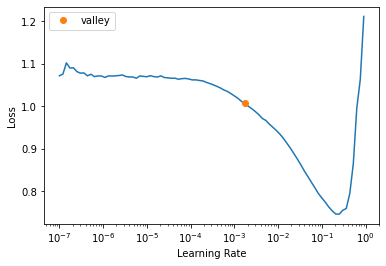

In [19]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=116)

monitor='valid_loss'
wd = 0.2

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet34_vl_480px_wd0.2'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.705784,0.432098,0.593389,13:01
1,0.323915,0.182247,0.754003,12:53


Better model found at epoch 0 with valid_loss value: 0.43209800124168396.


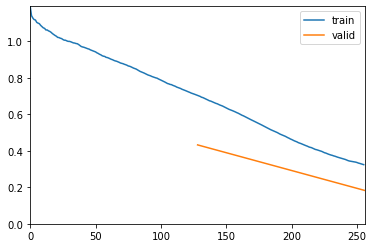

Better model found at epoch 1 with valid_loss value: 0.1822466254234314.


epoch,train_loss,valid_loss,f1_score,time
0,0.180985,0.123077,0.845436,13:08
1,0.145186,0.104847,0.869423,13:11
2,0.119951,0.092903,0.881475,13:08
3,0.106869,0.087598,0.890765,13:06
4,0.094942,0.085763,0.896248,13:07
5,0.087049,0.090298,0.884667,13:06
6,0.079294,0.085911,0.891294,14:52
7,0.074876,0.090525,0.896740,16:02


Better model found at epoch 0 with valid_loss value: 0.12307687103748322.


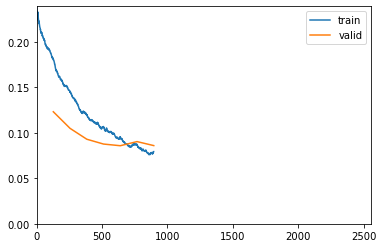

Better model found at epoch 1 with valid_loss value: 0.10484708100557327.
Better model found at epoch 2 with valid_loss value: 0.09290266782045364.
Better model found at epoch 3 with valid_loss value: 0.08759795874357224.
Better model found at epoch 4 with valid_loss value: 0.08576320111751556.
No improvement since epoch 4: early stopping


In [20]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [21]:
learn.export('plant_resnet34_vl_480px_wd0.2.pkl') # save the model

## resnet34 wd practice 0.3

SuggestedLRs(valley=0.0020892962347716093)

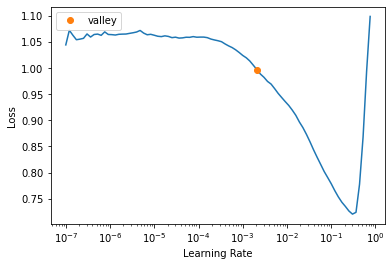

In [16]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=116)

monitor='valid_loss'
wd = 0.3

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet34_vl_480px_wd0.3'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.670999,0.399001,0.630772,12:44
1,0.302300,0.180111,0.788916,12:52


Better model found at epoch 0 with valid_loss value: 0.39900147914886475.


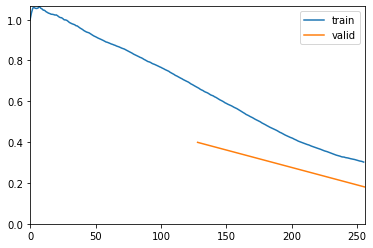

Better model found at epoch 1 with valid_loss value: 0.18011055886745453.


epoch,train_loss,valid_loss,f1_score,time
0,0.162497,0.125998,0.842271,12:52
1,0.132793,0.107974,0.870175,12:59
2,0.111878,0.103992,0.874287,13:05
3,0.098836,0.098344,0.882073,13:03
4,0.092487,0.095858,0.886507,13:00
5,0.082561,0.091326,0.888740,13:09
6,0.075183,0.099976,0.889059,13:06
7,0.070316,0.099512,0.893527,13:07
8,0.059720,0.104835,0.883831,13:11


Better model found at epoch 0 with valid_loss value: 0.12599848210811615.


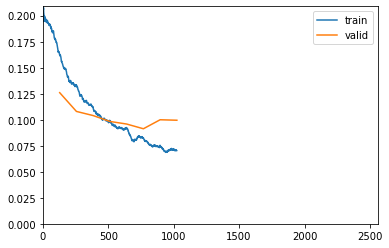

Better model found at epoch 1 with valid_loss value: 0.1079736202955246.
Better model found at epoch 2 with valid_loss value: 0.10399197041988373.
Better model found at epoch 3 with valid_loss value: 0.09834367036819458.
Better model found at epoch 4 with valid_loss value: 0.09585817158222198.
Better model found at epoch 5 with valid_loss value: 0.09132587909698486.
No improvement since epoch 5: early stopping


In [17]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [18]:
learn.export('plant_resnet34_vl_480px_wd0.3.pkl') # save the model

## resnet34 wd practice 0.4

SuggestedLRs(valley=0.0010000000474974513)

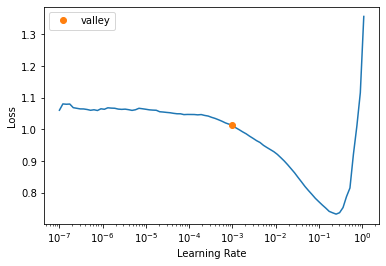

In [19]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=116)

monitor='valid_loss'
wd = 0.4

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet34_vl_480px_wd0.4'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.776046,0.495131,0.538647,12:52
1,0.429792,0.222165,0.758853,13:02


Better model found at epoch 0 with valid_loss value: 0.4951309561729431.


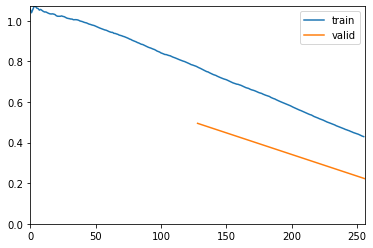

Better model found at epoch 1 with valid_loss value: 0.22216485440731049.


epoch,train_loss,valid_loss,f1_score,time
0,0.251207,0.165374,0.812257,13:07
1,0.196898,0.130243,0.838545,13:02
2,0.156791,0.108400,0.854968,13:05
3,0.127368,0.095438,0.875922,13:08
4,0.112860,0.088864,0.869819,13:21
5,0.099589,0.088471,0.883364,14:34
6,0.090419,0.084317,0.885706,13:05
7,0.081301,0.083181,0.888124,13:11
8,0.070935,0.083529,0.895310,13:11
9,0.063106,0.086780,0.898302,13:05


Better model found at epoch 0 with valid_loss value: 0.16537395119667053.


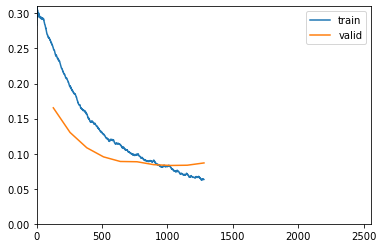

Better model found at epoch 1 with valid_loss value: 0.1302429735660553.
Better model found at epoch 2 with valid_loss value: 0.10840042680501938.
Better model found at epoch 3 with valid_loss value: 0.0954378992319107.
Better model found at epoch 4 with valid_loss value: 0.0888642817735672.
Better model found at epoch 5 with valid_loss value: 0.08847113698720932.
Better model found at epoch 6 with valid_loss value: 0.08431703597307205.
Better model found at epoch 7 with valid_loss value: 0.08318135887384415.
No improvement since epoch 7: early stopping


In [20]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [21]:
learn.export('plant_resnet34_vl_480px_wd0.4.pkl') # save the model

# Resnet50 480 Presize

## resnet50 wd practice 0.1

SuggestedLRs(valley=0.0014454397605732083)

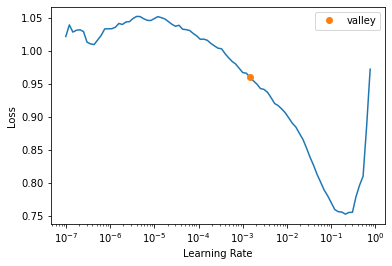

In [16]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=48)

monitor='valid_loss'
wd = 0.1

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet50_vl_480px_wd0.1'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.488119,0.293792,0.720506,13:55
1,0.197436,0.149599,0.819522,13:49


Better model found at epoch 0 with valid_loss value: 0.2937919795513153.


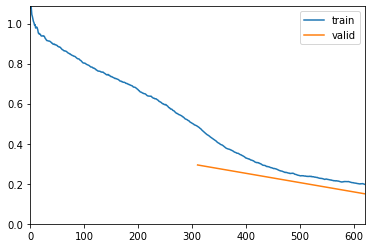

Better model found at epoch 1 with valid_loss value: 0.14959853887557983.


epoch,train_loss,valid_loss,f1_score,time
0,0.127980,0.107148,0.870575,13:52
1,0.114617,0.097366,0.876944,13:53
2,0.104174,0.099828,0.878742,13:46
3,0.095185,0.099299,0.885534,13:51
4,0.093381,0.089665,0.891876,13:49
5,0.084701,0.099268,0.883364,13:53
6,0.075314,0.088531,0.897558,13:49
7,0.066291,0.092834,0.897370,13:46
8,0.065064,0.100145,0.896690,13:52
9,0.056548,0.089123,0.899117,13:52


Better model found at epoch 0 with valid_loss value: 0.10714761912822723.


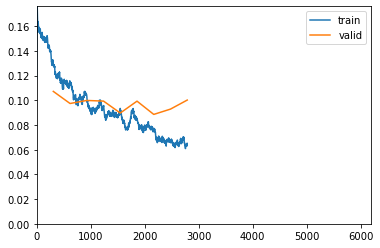

Better model found at epoch 1 with valid_loss value: 0.09736625850200653.
Better model found at epoch 4 with valid_loss value: 0.08966518193483353.
Better model found at epoch 6 with valid_loss value: 0.08853082358837128.
No improvement since epoch 6: early stopping


In [17]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [18]:
learn.export('plant_resnet50_vl_480px_wd0.1.pkl') # save the model

## resnet50 wd practice 0.2

SuggestedLRs(valley=0.0014454397605732083)

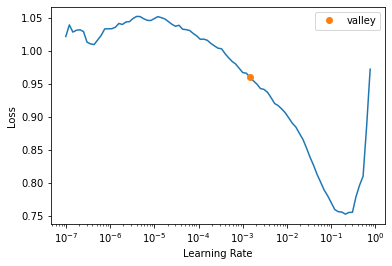

In [16]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=48)

monitor='valid_loss'
wd = 0.2

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet50_vl_480px_wd0.2'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.487072,0.294897,0.717971,13:25
1,0.195586,0.148432,0.825914,13:31


Better model found at epoch 0 with valid_loss value: 0.2948974668979645.


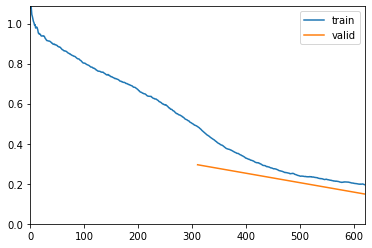

Better model found at epoch 1 with valid_loss value: 0.1484316736459732.


epoch,train_loss,valid_loss,f1_score,time
0,0.127142,0.107328,0.870355,13:35
1,0.114162,0.097359,0.877074,13:28
2,0.103187,0.099201,0.877375,13:34
3,0.094979,0.100786,0.880915,13:29
4,0.094311,0.089155,0.887960,13:34
5,0.083126,0.096171,0.889161,13:29
6,0.077816,0.085702,0.898767,13:28
7,0.066650,0.095709,0.889183,13:25
8,0.064821,0.100754,0.899486,13:20
9,0.056542,0.096257,0.892242,13:20


Better model found at epoch 0 with valid_loss value: 0.10732833296060562.


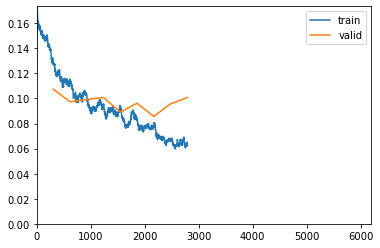

Better model found at epoch 1 with valid_loss value: 0.09735915064811707.
Better model found at epoch 4 with valid_loss value: 0.08915452659130096.
Better model found at epoch 6 with valid_loss value: 0.08570186048746109.
No improvement since epoch 6: early stopping


In [17]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [18]:
learn.export('plant_resnet50_vl_480px_wd0.2.pkl') # save the model

## resnet50 wd practice 0.3

SuggestedLRs(valley=0.0014454397605732083)

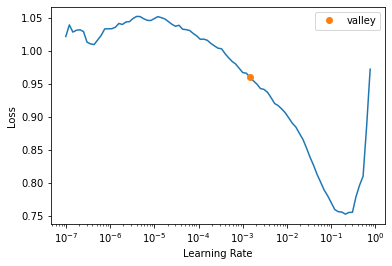

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=48)

monitor='valid_loss'
wd = 0.3

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet50_vl_480px_wd0.3'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.486107,0.297154,0.715665,12:50
1,0.195264,0.148570,0.822712,13:04


Better model found at epoch 0 with valid_loss value: 0.2971537113189697.


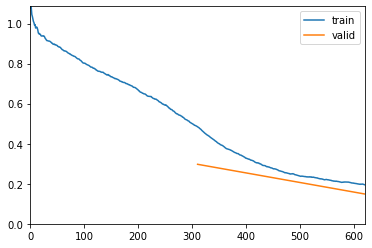

Better model found at epoch 1 with valid_loss value: 0.14857010543346405.


epoch,train_loss,valid_loss,f1_score,time
0,0.126189,0.107035,0.872136,13:10
1,0.112755,0.096952,0.881174,13:14
2,0.103800,0.099672,0.873653,13:15
3,0.093767,0.097595,0.886517,13:19
4,0.091115,0.091403,0.887193,13:26
5,0.084139,0.097480,0.883093,13:18
6,0.076911,0.087452,0.895934,13:17
7,0.065738,0.092440,0.890726,13:20
8,0.064397,0.099160,0.895940,13:24
9,0.059594,0.095414,0.892944,13:26


Better model found at epoch 0 with valid_loss value: 0.10703510791063309.


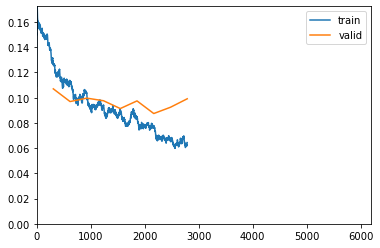

Better model found at epoch 1 with valid_loss value: 0.09695154428482056.
Better model found at epoch 4 with valid_loss value: 0.09140277653932571.
Better model found at epoch 6 with valid_loss value: 0.0874524787068367.
No improvement since epoch 6: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet50_vl_480px_wd0.3.pkl') # save the model

## resnet50 wd practice 0.4

SuggestedLRs(valley=0.0014454397605732083)

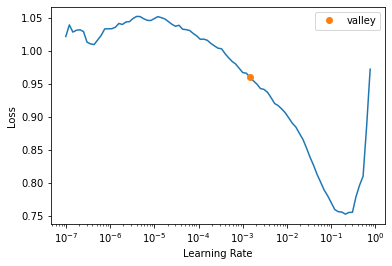

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=48)

monitor='valid_loss'
wd = 0.4

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet50_vl_480px_wd0.4'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.485318,0.294676,0.720703,13:26
1,0.194789,0.149408,0.822045,13:34


Better model found at epoch 0 with valid_loss value: 0.2946762144565582.


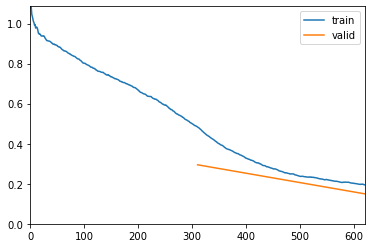

Better model found at epoch 1 with valid_loss value: 0.14940810203552246.


epoch,train_loss,valid_loss,f1_score,time
0,0.125784,0.107184,0.869133,13:35
1,0.113593,0.096626,0.880502,13:38
2,0.103231,0.098124,0.880412,13:35
3,0.092641,0.100636,0.881471,13:26
4,0.090873,0.087751,0.892138,13:26
5,0.083740,0.096394,0.883755,13:26
6,0.074758,0.087619,0.899118,13:27
7,0.066426,0.088618,0.896987,13:31
8,0.064122,0.093519,0.895911,13:22
9,0.057939,0.091413,0.899322,13:22


Better model found at epoch 0 with valid_loss value: 0.1071835607290268.


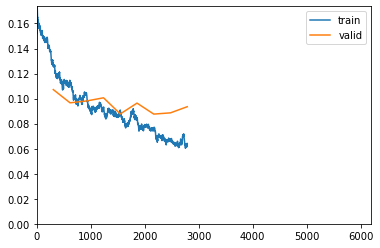

Better model found at epoch 1 with valid_loss value: 0.0966256782412529.
Better model found at epoch 4 with valid_loss value: 0.0877508670091629.
Better model found at epoch 6 with valid_loss value: 0.08761921525001526.
No improvement since epoch 6: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet50_vl_480px_wd0.4.pkl') # save the model

# Resnet101 480 Presize

## resnet101 wd practice 0.1

SuggestedLRs(valley=0.0012022644514217973)

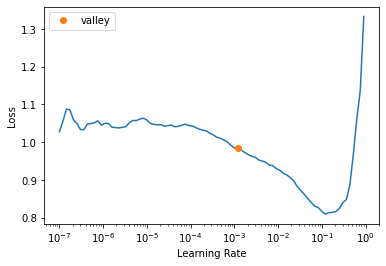

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=32)

monitor='valid_loss'
wd = 0.1

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet101_vl_480px_wd0.1'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.426531,0.260365,0.745277,13:14
1,0.176565,0.133432,0.841306,13:13


Better model found at epoch 0 with valid_loss value: 0.2603651285171509.


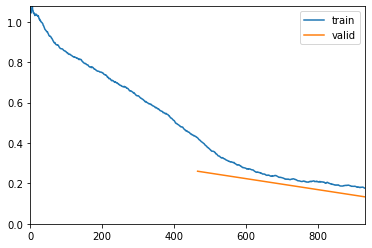

Better model found at epoch 1 with valid_loss value: 0.13343234360218048.


epoch,train_loss,valid_loss,f1_score,time
0,0.113896,0.097969,0.880025,13:27
1,0.111197,0.090109,0.877689,13:29
2,0.103713,0.090900,0.886797,13:22
3,0.099807,0.094223,0.883835,14:13
4,0.102570,0.093974,0.882741,14:27


Better model found at epoch 0 with valid_loss value: 0.09796862304210663.


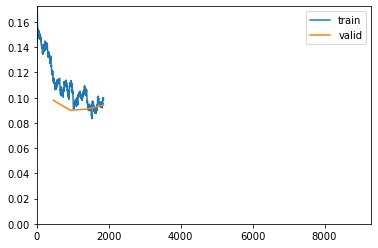

Better model found at epoch 1 with valid_loss value: 0.09010938555002213.
No improvement since epoch 1: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet101_vl_480px_wd0.1.pkl') # save the model

## resnet101 wd practice 0.2

SuggestedLRs(valley=0.0012022644514217973)

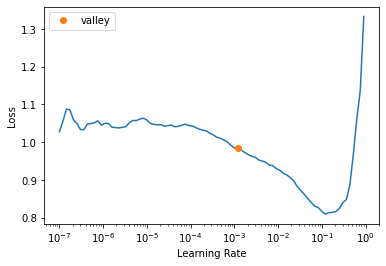

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=32)

monitor='valid_loss'
wd = 0.2

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet101_vl_480px_wd0.2'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.425383,0.258748,0.750512,13:22
1,0.176660,0.133766,0.841700,13:24


Better model found at epoch 0 with valid_loss value: 0.2587480843067169.


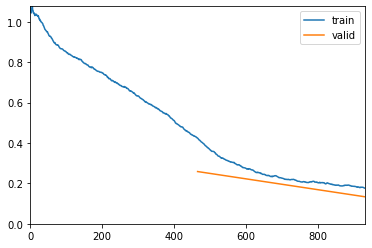

Better model found at epoch 1 with valid_loss value: 0.13376648724079132.


epoch,train_loss,valid_loss,f1_score,time
0,0.113797,0.098822,0.880837,13:28
1,0.110255,0.090134,0.880973,13:28
2,0.103654,0.091552,0.884597,13:37
3,0.100482,0.097533,0.883228,13:24
4,0.100187,0.094835,0.880894,13:28


Better model found at epoch 0 with valid_loss value: 0.09882193803787231.


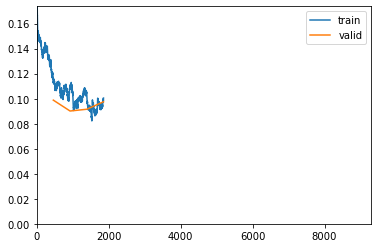

Better model found at epoch 1 with valid_loss value: 0.09013437479734421.
No improvement since epoch 1: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet101_vl_480px_wd0.2.pkl') # save the model

## resnet101 wd practice 0.3

SuggestedLRs(valley=0.0012022644514217973)

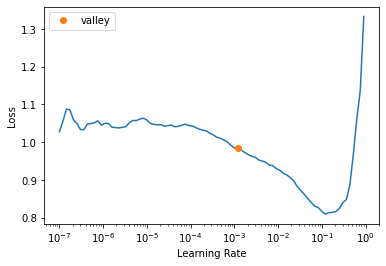

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=32)

monitor='valid_loss'
wd = 0.3

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet101_vl_480px_wd0.3'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.425161,0.259788,0.749934,13:19
1,0.176759,0.133566,0.841190,13:25


Better model found at epoch 0 with valid_loss value: 0.2597881853580475.


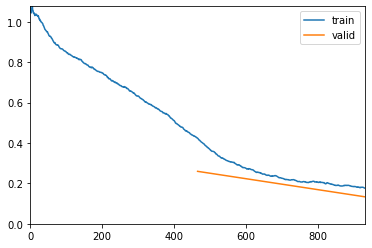

Better model found at epoch 1 with valid_loss value: 0.13356593251228333.


epoch,train_loss,valid_loss,f1_score,time
0,0.112919,0.098514,0.881071,13:34
1,0.109468,0.091079,0.880087,13:33
2,0.102054,0.089477,0.888732,13:27
3,0.098942,0.095589,0.887514,13:29
4,0.097516,0.092060,0.881136,13:29
5,0.086139,0.096672,0.887192,13:26


Better model found at epoch 0 with valid_loss value: 0.09851446747779846.


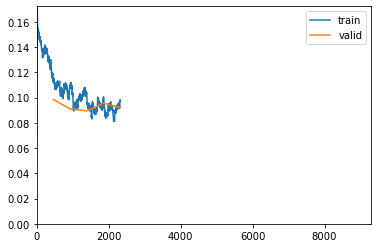

Better model found at epoch 1 with valid_loss value: 0.0910789966583252.
Better model found at epoch 2 with valid_loss value: 0.08947670459747314.
No improvement since epoch 2: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet101_vl_480px_wd0.3.pkl') # save the model

## resnet101 wd practice 0.4

SuggestedLRs(valley=0.0012022644514217973)

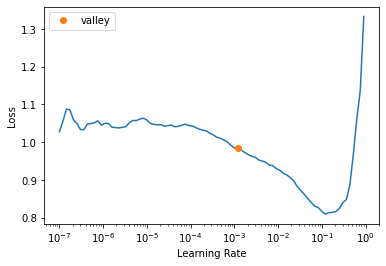

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=32)

monitor='valid_loss'
wd = 0.4

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet101_vl_480px_wd0.4'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.423531,0.261942,0.748956,13:09
1,0.173604,0.134606,0.837574,13:15


Better model found at epoch 0 with valid_loss value: 0.2619420289993286.


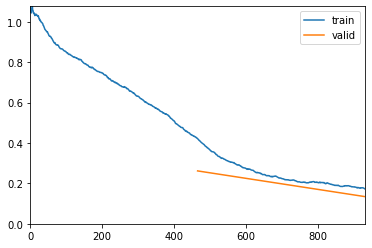

Better model found at epoch 1 with valid_loss value: 0.13460560142993927.


epoch,train_loss,valid_loss,f1_score,time
0,0.112141,0.098871,0.878121,13:24
1,0.107952,0.089909,0.881197,13:29
2,0.102025,0.090933,0.884254,13:24
3,0.098196,0.100094,0.879537,13:24
4,0.100064,0.092471,0.891433,13:27


Better model found at epoch 0 with valid_loss value: 0.09887050837278366.


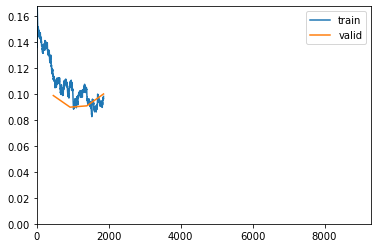

Better model found at epoch 1 with valid_loss value: 0.08990920335054398.
No improvement since epoch 1: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet101_vl_480px_wd0.4.pkl') # save the model

# Resnet152 480 Presize

## resnet152 wd practice 0.1

SuggestedLRs(valley=0.0012022644514217973)

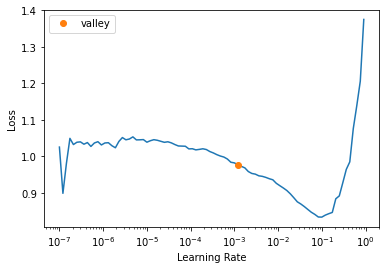

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=22)

monitor='valid_loss'
wd = 0.1

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet152_vl_480px_wd0.1'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.346832,0.216851,0.770185,13:12
1,0.169691,0.126226,0.852942,13:31


Better model found at epoch 0 with valid_loss value: 0.21685057878494263.


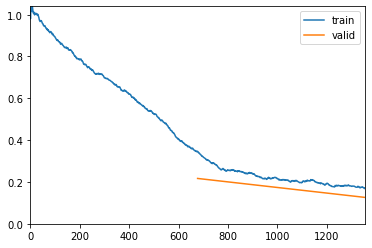

Better model found at epoch 1 with valid_loss value: 0.126225546002388.


epoch,train_loss,valid_loss,f1_score,time
0,0.113489,0.100395,0.880981,13:48
1,0.111660,0.093857,0.880539,13:57
2,0.109441,0.092997,0.887227,14:32
3,0.109085,0.097066,0.886820,13:55
4,0.106816,0.088553,0.893125,14:01
5,0.093968,0.090935,0.882530,14:00
6,0.090957,0.101195,0.880795,14:03
7,0.077957,0.084913,0.896629,14:00
8,0.075810,0.082192,0.905778,13:56
9,0.072883,0.087294,0.902488,13:56


Better model found at epoch 0 with valid_loss value: 0.10039518773555756.


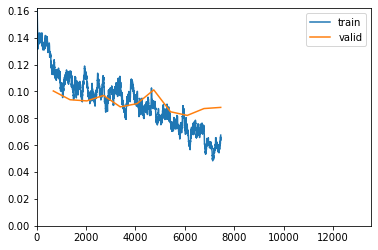

Better model found at epoch 1 with valid_loss value: 0.09385659545660019.
Better model found at epoch 2 with valid_loss value: 0.0929967612028122.
Better model found at epoch 4 with valid_loss value: 0.08855284005403519.
Better model found at epoch 7 with valid_loss value: 0.08491308242082596.
Better model found at epoch 8 with valid_loss value: 0.08219245076179504.
No improvement since epoch 8: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet152_vl_480px_wd0.1.pkl') # save the model

## resnet152 wd practice 0.2

SuggestedLRs(valley=0.0012022644514217973)

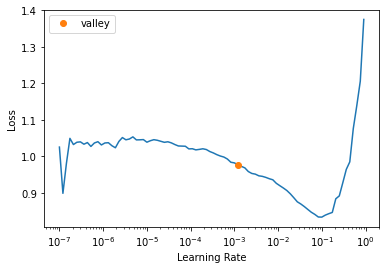

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=22)

monitor='valid_loss'
wd = 0.2

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet152_vl_480px_wd0.2'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.346990,0.218951,0.767157,13:28
1,0.167143,0.126169,0.855041,14:14


Better model found at epoch 0 with valid_loss value: 0.21895134449005127.


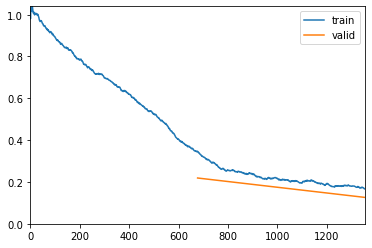

Better model found at epoch 1 with valid_loss value: 0.12616893649101257.


epoch,train_loss,valid_loss,f1_score,time
0,0.113641,0.100411,0.883103,14:01
1,0.110936,0.093271,0.879093,13:57
2,0.108167,0.090215,0.885049,14:03
3,0.107169,0.095460,0.883962,14:06
4,0.109718,0.091090,0.889901,14:00
5,0.094945,0.089980,0.891150,13:59
6,0.090518,0.093601,0.891219,14:00
7,0.077773,0.082059,0.905203,14:00
8,0.074394,0.084379,0.904549,13:53
9,0.077752,0.087642,0.899082,13:59


Better model found at epoch 0 with valid_loss value: 0.10041111707687378.


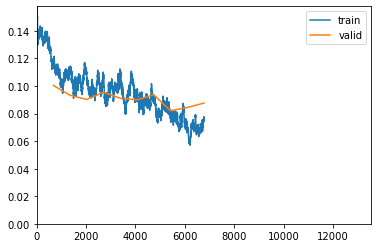

Better model found at epoch 1 with valid_loss value: 0.09327062219381332.
Better model found at epoch 2 with valid_loss value: 0.09021537005901337.
Better model found at epoch 5 with valid_loss value: 0.08997995406389236.
Better model found at epoch 7 with valid_loss value: 0.08205873519182205.
No improvement since epoch 7: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet152_vl_480px_wd0.2.pkl') # save the model

## resnet152 wd practice 0.3

SuggestedLRs(valley=0.0012022644514217973)

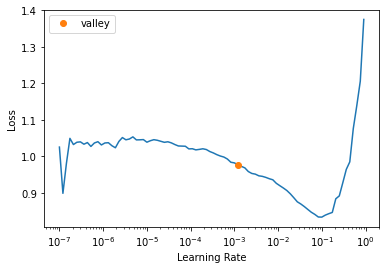

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=22)

monitor='valid_loss'
wd = 0.3

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet152_vl_480px_wd0.3'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.344495,0.218954,0.769801,13:36
1,0.165719,0.128966,0.850897,13:37


Better model found at epoch 0 with valid_loss value: 0.2189544290304184.


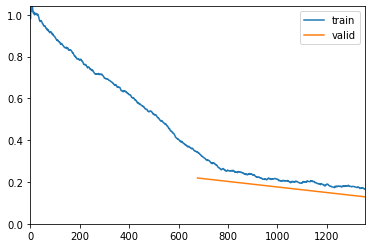

Better model found at epoch 1 with valid_loss value: 0.12896591424942017.


epoch,train_loss,valid_loss,f1_score,time
0,0.113556,0.100411,0.881665,13:52
1,0.111154,0.092973,0.882432,13:55
2,0.112390,0.092689,0.884047,13:52
3,0.107774,0.094599,0.882439,13:55
4,0.107238,0.092534,0.890482,13:52
5,0.096027,0.090812,0.889301,13:53
6,0.097840,0.088563,0.894795,13:53
7,0.078468,0.084613,0.897174,13:51
8,0.080158,0.082158,0.909160,13:53
9,0.072311,0.084651,0.900750,13:54


Better model found at epoch 0 with valid_loss value: 0.10041142255067825.


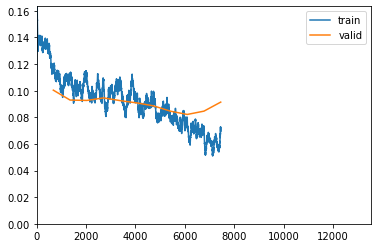

Better model found at epoch 1 with valid_loss value: 0.09297270327806473.
Better model found at epoch 2 with valid_loss value: 0.09268923848867416.
Better model found at epoch 4 with valid_loss value: 0.0925343781709671.
Better model found at epoch 5 with valid_loss value: 0.09081153571605682.
Better model found at epoch 6 with valid_loss value: 0.08856308460235596.
Better model found at epoch 7 with valid_loss value: 0.08461309224367142.
Better model found at epoch 8 with valid_loss value: 0.08215828239917755.
No improvement since epoch 8: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet152_vl_480px_wd0.3.pkl') # save the model

## resnet152 wd practice 0.4

SuggestedLRs(valley=0.0012022644514217973)

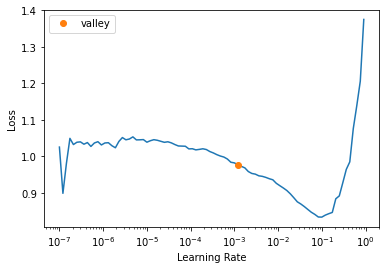

In [15]:
dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(presize_cpu),
    batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=22)

monitor='valid_loss'
wd = 0.4

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet152_vl_480px_wd0.4'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.344694,0.218087,0.771040,13:14
1,0.166069,0.128847,0.850459,13:29


Better model found at epoch 0 with valid_loss value: 0.21808739006519318.


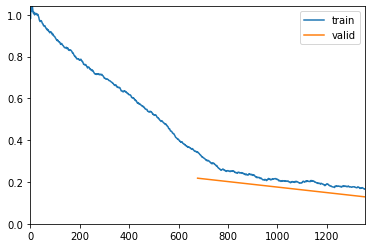

Better model found at epoch 1 with valid_loss value: 0.1288466602563858.


epoch,train_loss,valid_loss,f1_score,time
0,0.112540,0.098638,0.881419,13:49
1,0.108895,0.092552,0.881580,13:56
2,0.107931,0.094490,0.885829,13:54
3,0.108939,0.095970,0.881508,13:52
4,0.109652,0.095643,0.890286,13:52


Better model found at epoch 0 with valid_loss value: 0.09863783419132233.


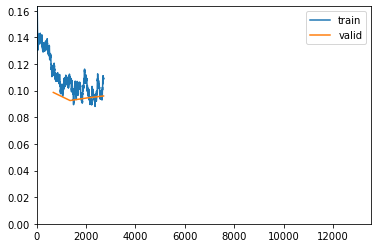

Better model found at epoch 1 with valid_loss value: 0.09255245327949524.
No improvement since epoch 1: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

In [17]:
learn.export('plant_resnet152_vl_480px_wd0.4.pkl') # save the model